In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy

In [2]:
from sklearn.model_selection import KFold, cross_val_predict,cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV, RidgeCV

In [3]:
def check_skew(df):
    """function to check the normality of the float columns of a dataframe. Uses D'Agostino's K-Squared test"""
    
    skewlist=[]
    vallist=[]
    
    X_cols=df.select_dtypes(include='float').columns.to_list()

    for col in X_cols:
        ob=normaltest(df[col])
        if ob.pvalue < 0.05:
            skewlist.append(col)
            vallist.append(min(df[col])) #keep track of min value to ensure we are only working with nonnegative data
            
    return skewlist, vallist       


In [4]:
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
from sklearn.preprocessing import StandardScaler

**Load in dataset after EDA and cleaning.** 

See Course 1 for details.

In [5]:
df_cleaner=pd.read_csv('df_clean.csv')

In [6]:
df_coef=pd.DataFrame() #initialize dataframe to store R2 coefficients for comparison

In [7]:
df=df_cleaner.copy() #df used to check skews and normalize 
df_bmi=df_cleaner.copy() #keep this copy before all the transformations so that 
#list of groups can be appended to a human interpretable version

### Split the dataset

In [8]:
X_data=df_cleaner.drop(columns=['BodyFat', 'Density'])
Y_data=df_cleaner['BodyFat']

#transform skewed distributions

skew,_=check_skew(X_data)

for x in skew:
    X_data[x]=np.log(X_data[x])

X_train, X_test, y_train, y_test=train_test_split(X_data, Y_data, test_size=0.3, random_state=72018)

# Baseline Lasso Regression - No Clustering

In [9]:
s=StandardScaler()

X_train_s=s.fit_transform(X_train)
X_test_s=s.transform(X_test)

print('Lasso Regression')

#Use the lassoCV function to tune alpha

lassoCV=LassoCV(alphas=np.linspace(.0065,.065,20),
                  max_iter=5e4,
                  cv=3).fit(X_train_s, y_train)

alpha=lassoCV.alpha_
print('alpha =', alpha)

y_pred_lasso=lassoCV.predict(X_test_s)
r2=r2_score(y_test,y_pred_lasso)

Lasso Regression
alpha = 0.037289473684210525


In [10]:
s=StandardScaler()

X_train_s=s.fit_transform(X_train)
X_test_s=s.transform(X_test)

print('Lasso Regression')

#Use the lassoCV function to tune alpha

lassoCV=LassoCV(alphas=np.linspace(.0065,.065,20),
                  max_iter=5e4,
                  cv=3).fit(X_train_s, y_train)

alpha=lassoCV.alpha_
print('alpha =', alpha)

y_pred_lasso=lassoCV.predict(X_test_s)
r2=r2_score(y_test,y_pred_lasso)

#these try/except blocks were required in development because the axes of df_coef are transposed at the end.
#they are not required for running and reading unless changes are made to the hyperparameters.

try:
    df_coef['NO_Cluster']=[r2, len(X_data)]
    
except:
    df_coef.loc['NO_Cluster','R2']=r2
    df_coef.loc['NO_Cluster','NumPoints']=len(X_data)

print('r2 =', r2)

print('sum of coef = ',abs(lassoCV.coef_).sum())

Lasso Regression
alpha = 0.037289473684210525
r2 = 0.6762184193092151
sum of coef =  15.959933619993802


**Feature Importances**

In [11]:
lasc=lassoCV.coef_
cols=X_data.columns.to_list()
coefdf=pd.DataFrame(lasc,cols)
coefdf.rename({0:'LASSO'},axis=1,inplace=True)

The intuition motivated goal of the unsupervised clustering is to see if the models are able to identify the obese/not obese split at BMI=25.  

However, any cluster which normalizes feature distributions could provide an improvement to the regression models.

Perhaps the algorithms will give some surprising results.

In [12]:
df_final=df_bmi.copy() #df to label the cluster assignments of each algorithm

df=df_bmi.copy().drop(columns='BMI') #untransformed (skewed) data with the BMI column dropped -
#                                     I don't want to give any hints to the algorithm 

The X dataframe will be used for all clustering algorithms.   I want to leave the BMI feature off to see if it can 
#be found through clustering.

In [13]:
Xu=df.drop(columns=['Density','BodyFat']) #these are related to targets
y=df['BodyFat']

skewed,l=check_skew(Xu)

#normalize the distributions for the KNN algorithm
for i in skewed:
    Xu[i]=np.log(Xu[i])

s=StandardScaler() #scaling is important for distance based algorithms
X=s.fit_transform(Xu)

# DMDBSCAN Clustering

DM stands for Dynamic Method, and is a technique for determining the optimal epsilon in the DBSCAN algorithm.

This technique was developed to handle datasets with clusters of varying densities.

In this case, we do not have density variation amongst clusters - this technique is simply used to find the radius to the outliers.

In [14]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

#the combination of these two will yield the DMDBSCAN algorithm

Code to compute the distance to the nearest neighbor for each point.

In [15]:
neigh=NearestNeighbors(n_neighbors=5)
nbrs=neigh.fit(X)
distances,indices=nbrs.kneighbors(X)

Plot the distance to the nearest neighbor for each point. This plot is used to choose epsilon for DBSCAN.

Text(0.5, 1.0, 'DMDBSCAN - epsilon')

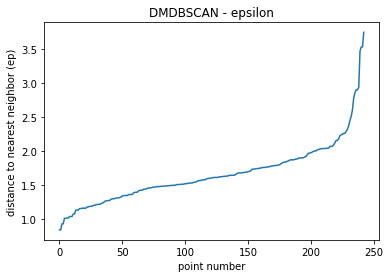

In [16]:
distances=np.sort(distances, axis=0) #sorts each points distance to neighbor
distances1=distances[:,1] #keep the first nonzero entry of each row array
plt.plot(distances1)

plt.xlabel('point number')
plt.ylabel('distance to nearest neighbor (ep)')
plt.title('DMDBSCAN - epsilon')

We see that distances to the nearest neighbor increase drastically at point number ~230. Use this distance value as epsilon.

The next hyperparameter is the minimum number of points in the neighborhood of a core point.

Determine this by analyzing how the number of outliers trends with the min_samples.

In [17]:
outliers=[]
ep=2.25
for i in range(1,25):
    dbs=DBSCAN(eps=ep,min_samples=i, metric='euclidean')
    dbs.fit(X)
    outliers.append(np.count_nonzero(dbs.labels_==-1))

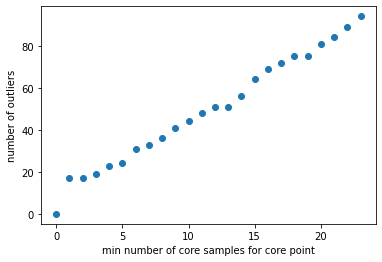

In [18]:
plt.plot(outliers,'o')
plt.xlabel('min number of core samples for core point')
plt.ylabel('number of outliers')
plt.show()

From above, min_samples=2.

In [19]:
#fit the DBSCAN model with the optimized epsilon and min_samples

dbs=DBSCAN(eps=ep,min_samples=2, metric='euclidean')
dbs.fit(X)

print('number of outliers =', np.count_nonzero(dbs.labels_==-1))
print('number of clustered points =',np.count_nonzero(dbs.labels_!=-1))
print('cluster labels: ',np.unique(dbs.labels_))

#label original dataset for comparison of algorithms
df_final['Cluster_Assign_DB']=dbs.labels_

number of outliers = 17
number of clustered points = 226
cluster labels:  [-1  0]


# Lasso Regression - DBSCAN Clustering

In [20]:
#use the bmi feature for the regression.
df_cluster=df_bmi.copy()

#add cluster labels to separate out outliers
#outliers are always -1 for DBSCAN

df_cluster['Cluster_Assign_DB']=dbs.labels_
df_cluster=df_cluster[df_cluster['Cluster_Assign_DB']==0]

#drop outliers
df_cluster.drop(['Cluster_Assign_DB'],axis=1,inplace=True)

X_data=df_cluster.drop(columns=['BodyFat', 'Density'])
Y_data=df_cluster['BodyFat']
    
# test train split after outliers are removed  
X_train, X_test, y_train, y_test=train_test_split(X_data, Y_data, test_size=0.3, random_state=72018)

In [21]:
s=StandardScaler()
X_train_s=s.fit_transform(X_train)
X_test_s=s.transform(X_test)

print('Lasso Regression')

lassoCV=LassoCV(alphas=np.linspace(.01,1,200),
                  max_iter=5e4,
                  cv=3).fit(X_train_s, y_train)

alpha=lassoCV.alpha_
print('alpha=', alpha)


y_pred_lasso=lassoCV.predict(X_test_s)
r2=r2_score(y_test,y_pred_lasso)

try: 
    df_coef['DBSCAN']=[r2,len(X_data)]
    
except:
    df_coef.loc['DBSCAN','R2']=r2
    df_coef.loc['DBSCAN','NumPoints']=len(X_data)

print('r2 =', r2)

print('sum of coef =', abs(lassoCV.coef_).sum())

Lasso Regression
alpha= 0.049798994974874375
r2 = 0.7085220796027615
sum of coef = 15.422207187493708


**Keep track of the feature importances for each model.**

In [22]:
lasc=lassoCV.coef_
cols=X_data.columns.to_list()
coefdf=coefdf.join(pd.DataFrame(lasc,cols,['DBSCAN']))

# KMEANS

In [23]:
from sklearn.cluster import KMeans

In [24]:
k2=KMeans(n_clusters=2,random_state=42)
k2.fit(X)

KMeans(n_clusters=2, random_state=42)

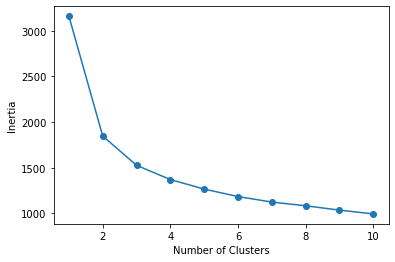

In [25]:
inertia=[]
list_num_clusters=list(range(1,11))
for num_clusters in list_num_clusters:
    km=KMeans(n_clusters=num_clusters)
    km.fit(X)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');


In [26]:
#label original dataset for comparison of algorithms
df_final['Cluster_Assign_kmeans']=k2.labels_

In [27]:
df_kmeans=df_bmi.copy()

#label the dataset used for the regression
df_kmeans['Cluster_Assign_kmeans']=k2.labels_

#look at which group corresponds to which label
print(df_kmeans[df_kmeans.Cluster_Assign_kmeans==1]['BMI'].mean())
print(df_kmeans[df_kmeans.Cluster_Assign_kmeans==0]['BMI'].mean())

28.009365986263422
23.235176154022998


# Lasso Regression - Kmeans Clustering - Cluster 0

KMEANS is not able to identify outliers like DBSCAN. The regression will be done on both clusters. The higher performance will be reported.

In [28]:
#training regression model on kmeans cluster 0

df_kr=df_kmeans[df_kmeans['Cluster_Assign_kmeans']==0]
df_cluster=df_kr.drop(columns=['Cluster_Assign_kmeans'])

#split the data with cluster 1 removed
X_data=df_cluster.drop(columns=['BodyFat', 'Density'])
Y_data=df_cluster['BodyFat']
    
X_train, X_test, y_train, y_test=train_test_split(X_data, Y_data, test_size=0.3, random_state=72018)

#scale
s=StandardScaler()
X_train_s=s.fit_transform(X_train)
X_test_s=s.transform(X_test)

print('Lasso Regression')

lassoCV0=LassoCV(alphas=np.linspace(.1,.5,200),
                  max_iter=5e4,
                  cv=3).fit(X_train_s, y_train)

alpha=lassoCV0.alpha_
print('alpha =', alpha)

y_pred_lasso=lassoCV0.predict(X_test_s)

r2h=r2_score(y_test,y_pred_lasso)

try: 
    df_coef['kmeans']=[r2h,len(X_data)]
   
except:    
    df_coef.loc['KMEANS','R2']=r2h
    df_coef.loc['KMEANS','NumPoints']=len(X_data)

#store coefficients
lasc=lassoCV0.coef_

print('r2 =', r2_score(y_test,y_pred_lasso))
print('sum of coef =',abs(lassoCV0.coef_).sum())

Lasso Regression
alpha = 0.15226130653266334
r2 = 0.45666263792061146
sum of coef = 8.822522122797691


# Lasso Regression - Kmeans Clustering - Cluster 1

In [29]:
#training regression model on kmeans cluster 1

df_kr=df_kmeans[df_kmeans['Cluster_Assign_kmeans']==1]
df_cluster=df_kr.drop(columns=['Cluster_Assign_kmeans'])

#split the data with cluster 0 removed
X_data=df_cluster.drop(columns=['BodyFat', 'Density'])
Y_data=df_cluster['BodyFat']

X_train, X_test, y_train, y_test=train_test_split(X_data, Y_data, test_size=0.3, random_state=72018)

#scale
s=StandardScaler()
X_train_s=s.fit_transform(X_train)
X_test_s=s.transform(X_test)

print('Lasso Regression')

lassoCV=LassoCV(alphas=np.linspace(.01,.5,200),
                  max_iter=5e4,
                  cv=3).fit(X_train_s, y_train)

alpha=lassoCV.alpha_
print('alpha=', alpha)

y_pred_lasso=lassoCV.predict(X_test_s)

r2=r2_score(y_test,y_pred_lasso)

if r2>r2h: #we only want to keep the higher scoring kmeans cluster/regression. 
    try: 
        df_coef['kmeans']=[r2,len(X_data)]
    except:    
        df_coef.loc['KMEANS','R2']=r2h
        df_coef.loc['KMEANS','NumPoints']=len(X_data)
        
    lasc=lassoCV.coef_

print('r2 =', r2_score(y_test,y_pred_lasso))
print('sum of coef =',abs(lassoCV.coef_).sum())

Lasso Regression
alpha= 0.46798994974874375
r2 = 0.6278570609242586
sum of coef = 7.503587336758982


**Feature Importances**

In [30]:
cols=X_data.columns.to_list()
coefdf=coefdf.join(pd.DataFrame(lasc,cols,['KMEANS']))

## HA Clustering

In [31]:
from sklearn.cluster import AgglomerativeClustering

In [32]:
HA=AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')

In [33]:
HA.fit(Xu) #training on unstandardized data leads to drastically better model performance
HA.labels_.sum()
df_final['Cluster_Assign_HA']=HA.labels_

In [34]:
#training regression model on HA cluster

df_ha=df_bmi.copy()
df_ha['Cluster_Assign_HA']=HA.labels_
df_ha_r=df_ha[df_ha['Cluster_Assign_HA']==0]

df_cluster=df_ha_r.drop(columns=['Cluster_Assign_HA'])

X_data=df_cluster.drop(columns=['BodyFat', 'Density'])
Y_data=df_cluster['BodyFat']

X_train, X_test, y_train, y_test=train_test_split(X_data, Y_data, test_size=0.3, random_state=72018)

s=StandardScaler()

X_train_s=s.fit_transform(X_train)
X_test_s=s.transform(X_test)

print('Lasso Regression')

#Use the lassoCV function to come up with alpha


lassoCV=LassoCV(alphas=np.linspace(.15,.25,20),
                  max_iter=5e4,
                  cv=3).fit(X_train_s, y_train)

alpha=lassoCV.alpha_
print('alpha=', alpha)

y_pred_lasso=lassoCV.predict(X_test_s)

r2=r2_score(y_test,y_pred_lasso)

try:
    df_coef['HA']=[r2,len(X_data)]
except:
    df_coef.loc['HA','R2']=r2h
    df_coef.loc['HA','NumPoints']=len(X_data)

print('r2 =', r2_score(y_test,y_pred_lasso))

print('sum of coef =',abs(lassoCV.coef_).sum())

Lasso Regression
alpha= 0.1868421052631579
r2 = 0.7217672447946247
sum of coef = 9.485850795297855


**Feature Importances**

In [35]:
lasc=lassoCV.coef_
cols=X_data.columns.to_list()
coefdf=coefdf.join(pd.DataFrame(lasc,cols,['HA']))


In [36]:
#final feature importances
coefdf.sort_values(by='HA')

,LASSO,DBSCAN,KMEANS,HA
Height,-0.667473,-0.219265,-0.626972,-1.160461
Ankle,-0.377767,-0.000000,0.000000,-0.480510
Wrist,-1.313316,-1.480734,-0.655426,-0.428996
Neck,-1.202657,-0.702810,0.000000,-0.029024
BMI,1.682588,0.551865,0.000000,0.000000
Age,0.552434,1.252737,0.652906,0.000000
Weight,0.000000,-0.000000,-0.000000,0.000000
Chest,-0.371825,-0.000000,-0.000000,0.000000
Hip,-0.684931,-1.400880,-0.000000,0.000000
Knee,0.204482,-0.575855,0.000000,-0.000000


In [37]:
# assemble R**2 table.
df_coef=df_coef.T
df_coef.rename(columns={0:'R2',1:'NumPoints'}, inplace=True)


**Final Summary**

In [38]:
df_coef

,R2,NumPoints
NO_Cluster,0.676218,243.0
DBSCAN,0.708522,226.0
kmeans,0.627857,106.0
HA,0.721767,176.0


In [39]:
#df_final.to_csv('all2.csv')